In [1]:
#IMPORTS
import os
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
vehicle_dir = './vehicles/*/*.png'
non_vehicle_dir = './non-vehicles/*/*.png'

def read_imgs(vehicle_dir):
    imgs = glob.glob(vehicle_dir)
    cars = []
    for (idx, filename) in enumerate(imgs):
        cars.append(mpimg.imread(filename))
    return cars
    

vehicle_im = read_imgs(vehicle_dir)
non_vehicle_im = read_imgs(non_vehicle_dir)
print("Vehicles: " + str(len(vehicle_im)))
print("Non-Vehicles: " + str(len(non_vehicle_im)))

Vehicles: 8792
Non-Vehicles: 8968


In [3]:
##Lesson functions
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
#         image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        #image = image.astype(np.float32)/255
        try:
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

        except:
            continue
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=false, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


/Users/jtracy9/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


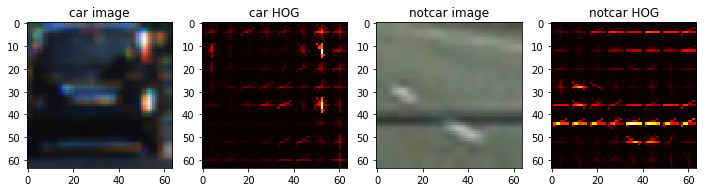

In [4]:
car_ind = np.random.randint(0, len(vehicle_im))
not_car_ind = np.random.randint(0, len(non_vehicle_im))

car = vehicle_im[car_ind]
notcar = non_vehicle_im[not_car_ind]

color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
imgs = [car, car_hog_image, notcar, notcar_hog_image]
titles = ['car image', 'car HOG', 'notcar image', 'notcar HOG']

fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, imgs, titles)


In [5]:
import csv
augment_path_im = "./object-detection-crowdai/"

augment_csv_im = "./object-detection-crowdai/labels_crowdai.csv"

augment_car_imgs = []

with open(augment_csv_im) as label_file:
    reader = csv.DictReader(label_file)
    i = 0
    num_images = 5000
    for row in reader:
        xmin = np.int32(row['xmin'])
        xmax = np.int32(row['xmax'])
        ymin = np.int32(row['ymin'])
        ymax = np.int32(row['ymax'])
        name = row['Frame']
        label = row['Label']
        img_src = augment_path_im + str(name)
        
        img = mpimg.imread(img_src)
        car = img[ymin:ymax, xmin:xmax]
        try:
            car = cv2.resize(car, (64,64))
            augment_car_imgs.append(car)
            i += 1
        except:
            continue

        if i >= num_images:
            break
#         plt.imshow(car)
#         plt.show()
print("added " + str(len(augment_car_imgs)) + " augmented images")
test_cars = vehicle_im + augment_car_imgs 
print("total car images: " + str(len(test_cars)))
print("total non-car images: " + str(len(non_vehicle_im)))

added 5000 augmented images
total car images: 13792
total non-car images: 8968


In [6]:

def extract_images(times_points, video_name):
    imgs = []
    cap = cv2.VideoCapture(video_name)
    
    fps = 30
    length = 50
    
    for row in times_points:
        video_time = row[0]
        xmin = row[1]
        xmax = row[2]
        ymin = row[3]
        ymax = row[4]
        frame_no = (video_time*fps)/(length * fps)
        
        cap.set(2,frame_no)

        ret, frame = cap.read()
        if ret:
            car = frame[ymin:ymax, xmin:xmax]
            try:
                car = cv2.resize(car, (64,64))
                imgs.append(car)
            except:
                continue
        else:
            continue
    
    return imgs



In [7]:
white_cars_points = [[22.0, 890, 1002, 400, 470], [23, 890, 990, 410, 460], [26,870,950,410,465], [27,860,945,410,465], [28,855,940,410,465],[29,870,950,410,465], [30,880,970,410,465]]
video_name = "./project_video.mp4"
white_cars = []
white_cars = extract_images(white_cars_points, video_name)
multiple = 1000
extra_cars = []
for num in range(0,multiple):
    extra_cars += white_cars
    
print("white cars from video:" + str(len(extra_cars)))



white cars from video:7000


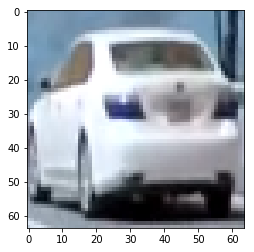

In [8]:
## get more training data for white cars
video_name = "./project_video.mp4"

#Open the video file
cap = cv2.VideoCapture(video_name)

fps = 30
length = 50
video_time = 22.0
frame_no = (video_time*fps)/(length * fps)

xmin = 890
xmax = 1002
ymin = 400
ymax = 470

cap.set(2,frame_no)

ret, frame = cap.read()
car = frame[ymin:ymax, xmin:xmax]
car = cv2.resize(car, (64,64))

#plt.imshow(frame)
plt.imshow(car)
plt.show()


In [9]:
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = len(non_vehicle_im)
random_idxs = np.random.randint(0, len(vehicle_im), n_samples)
cars = vehicle_im + augment_car_imgs + extra_cars

test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(non_vehicle_im)[random_idxs]
test_notcars = non_vehicle_im
#test_cars = cars
print("Total images: " + str(len(test_notcars) + len(test_cars)))
car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(time.time() - t, 'Seconds')
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Feature vector length: ', len(X_train[0]))

Total images: 17936


/Users/jtracy9/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


70.38346791267395 Seconds
Feature vector length:  6108


In [10]:
#TRAIN

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)
#try Decision trees, LinearSVC, LinearSVR, Naive bayes,
#svm.SVC() 99.5
svc = LinearSVC()

t = time.time()

svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

21.96 Seconds
Test Accuracy of SVC =  0.9944


0.0 1.0


/Users/jtracy9/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0382459163665771 seconds to process one image searching 190 windows
0.0 1.0
1.0867729187011719 seconds to process one image searching 190 windows
0.0 1.0
0.9665031433105469 seconds to process one image searching 190 windows
0.0 1.0
0.9280068874359131 seconds to process one image searching 190 windows
0.0 1.0
0.9072830677032471 seconds to process one image searching 190 windows
0.0 1.0
0.9041600227355957 seconds to process one image searching 190 windows


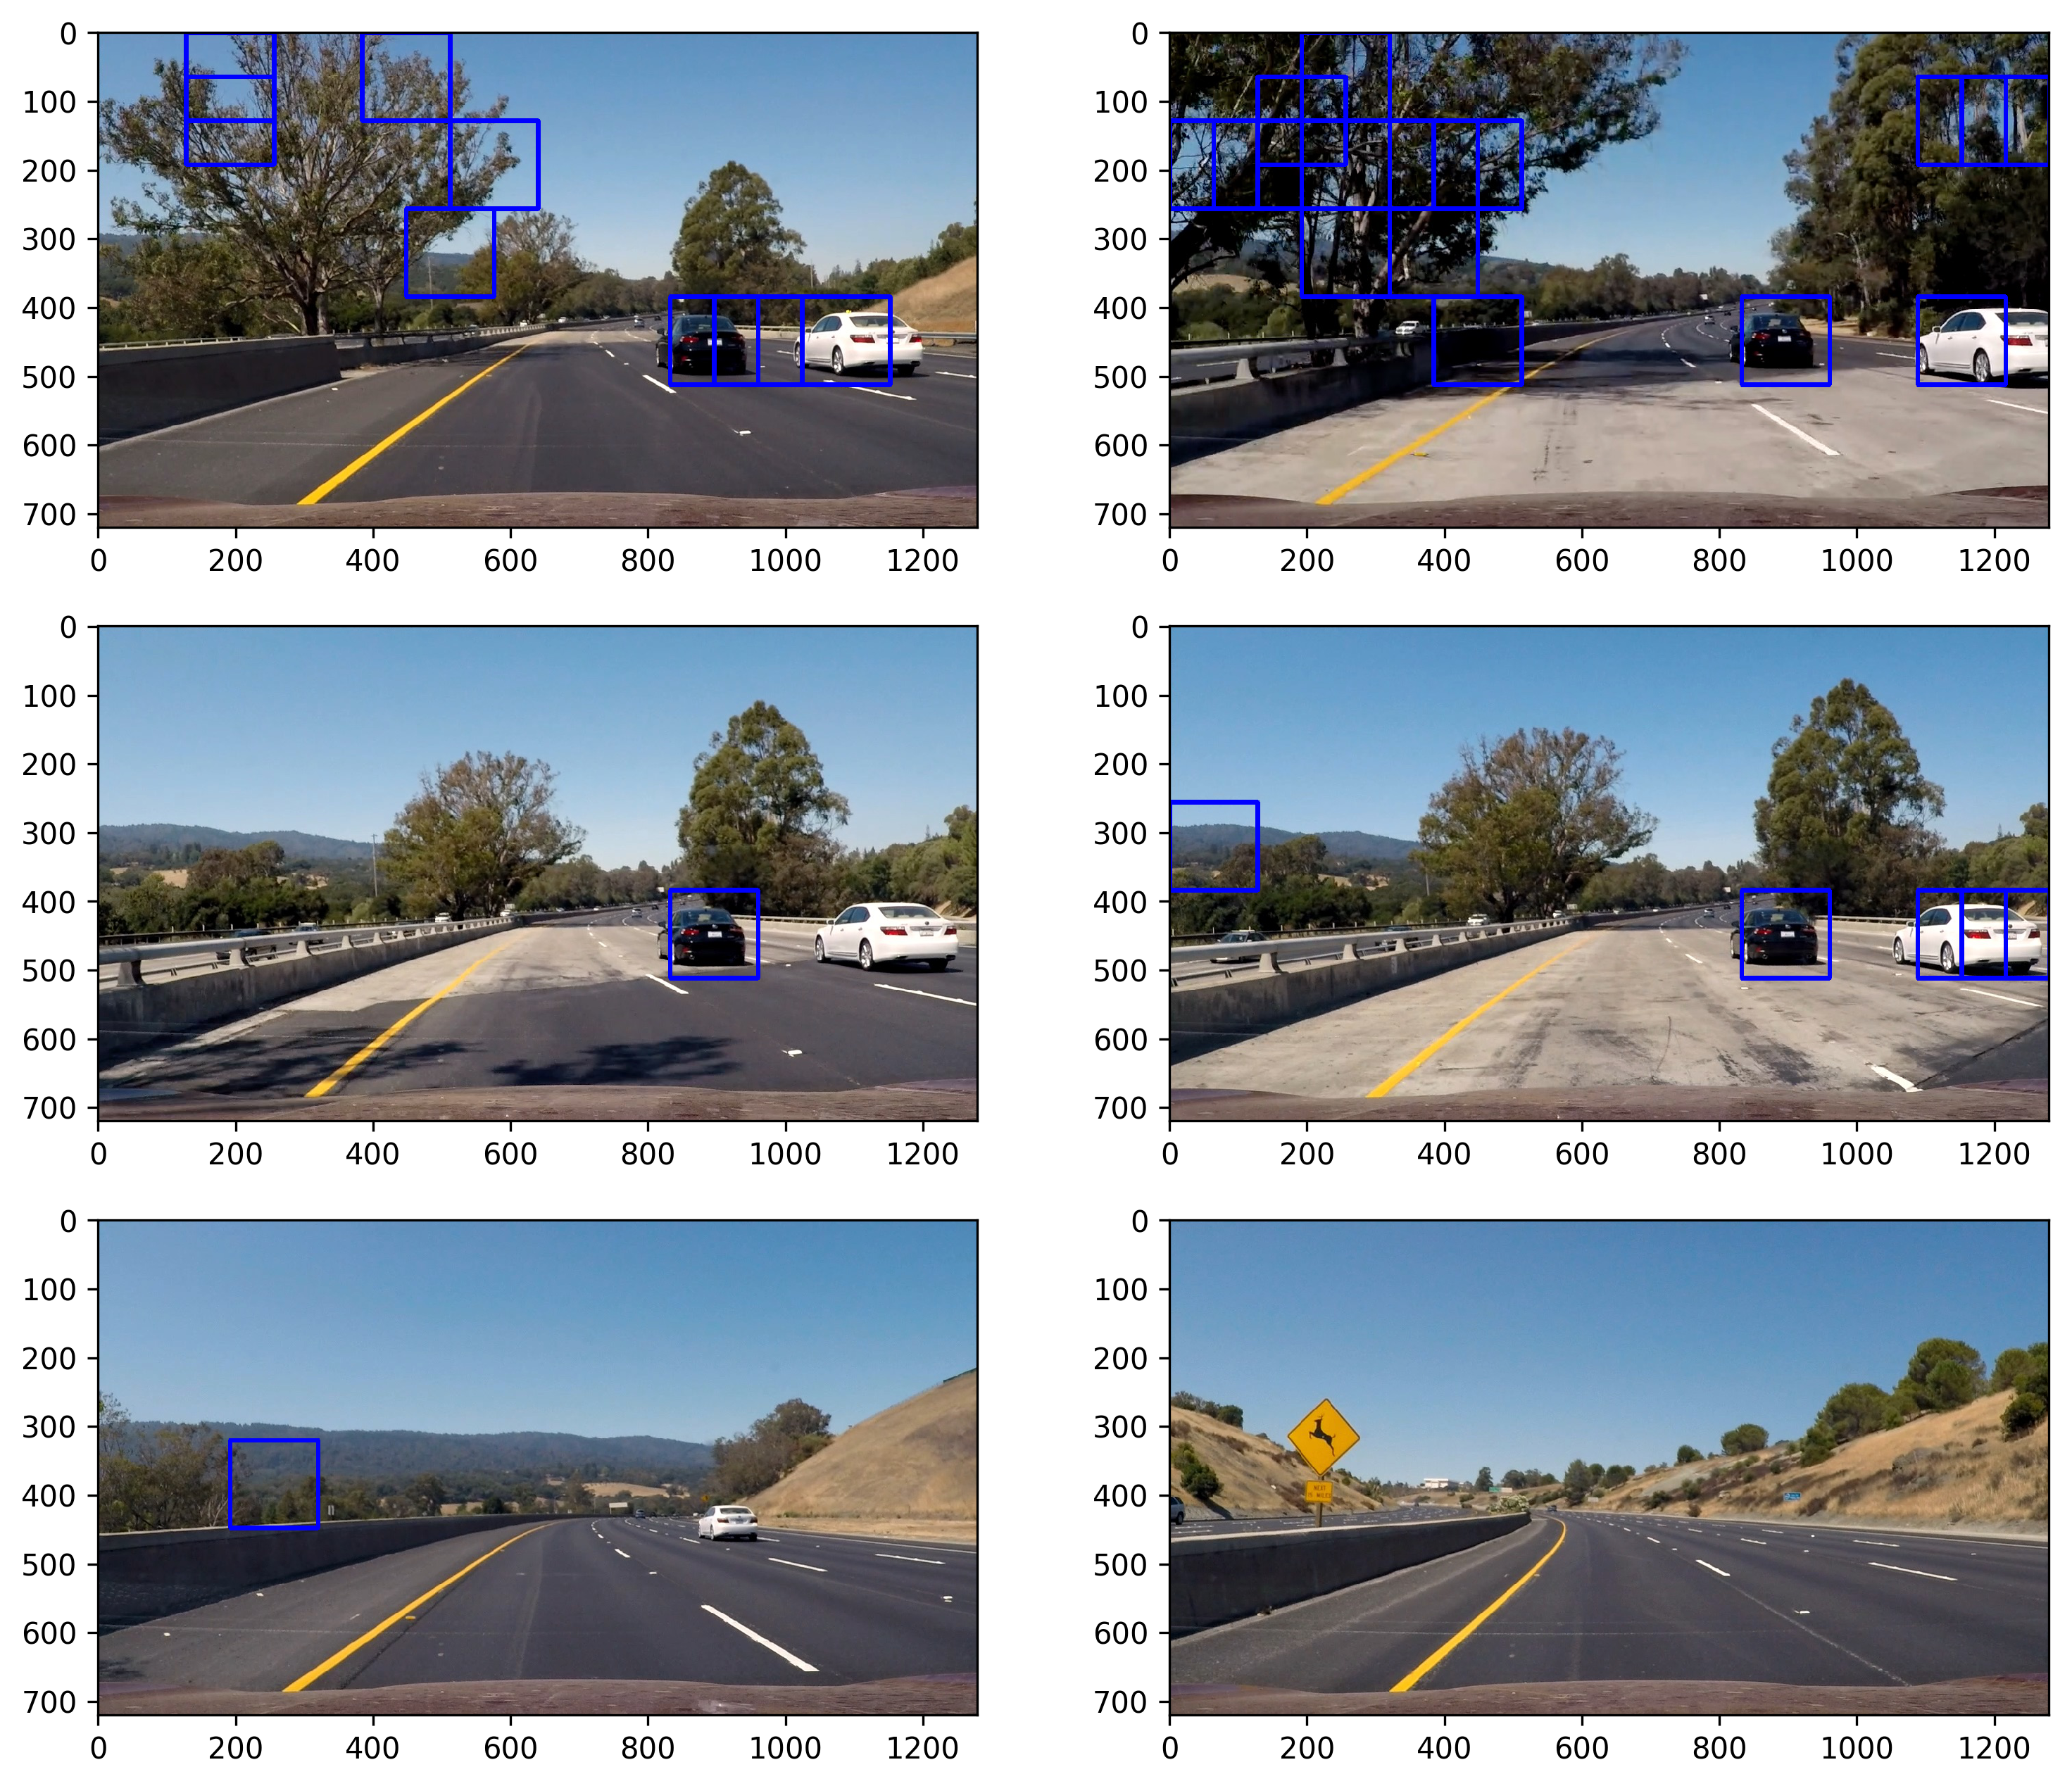

In [11]:
searchpath = "./test_images/*"
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [None, None]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(128,128),xy_overlap=(overlap,overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)
    

/Users/jtracy9/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0003128051757812 seconds to run, total windows =  912
1.1629090309143066 seconds to run, total windows =  912
1.0033361911773682 seconds to run, total windows =  912
0.9549999237060547 seconds to run, total windows =  912
0.9202649593353271 seconds to run, total windows =  912
0.9204659461975098 seconds to run, total windows =  912


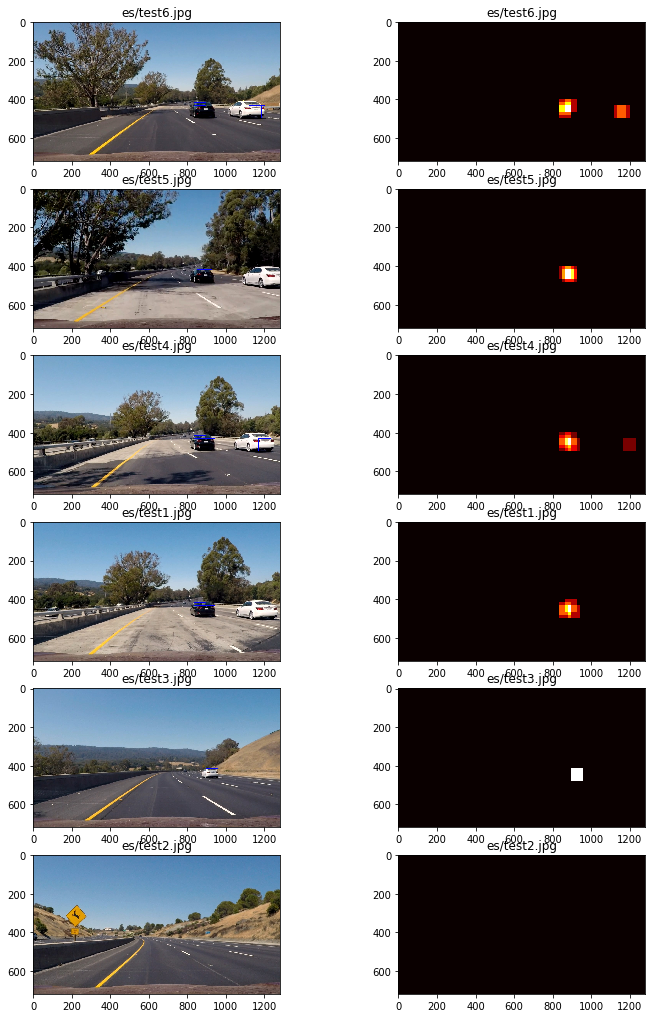

In [12]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.0
color_space = 'RGB2YCrCb'

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1

    nfeat_per_block = orient*cell_per_block**2

    window = 64

    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)

            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left + win_draw, ytop_draw+ win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                    
    print(time.time() - t, 'seconds to run, total windows = ', count)
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [13]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_s)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1

    nfeat_per_block = orient*cell_per_block**2

    window = 64

    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)

            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left + win_draw, ytop_draw+ win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap


In [14]:
def find_cars(img, scales):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_convert)
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1

        nfeat_per_block = orient*cell_per_block**2

        window = 64

        nblocks_per_window = (window // pix_per_cell) - 1

        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

                spatial_features = bin_spatial(subimg, size=spatial_size)

                hist_features = color_hist(subimg, nbins=hist_bins)

                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), (xbox_left + win_draw, ytop_draw+ win_draw+ystart),(0,0,255))
                    img_boxes.append(((xbox_left,ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

In [15]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+ 1):
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

/Users/jtracy9/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


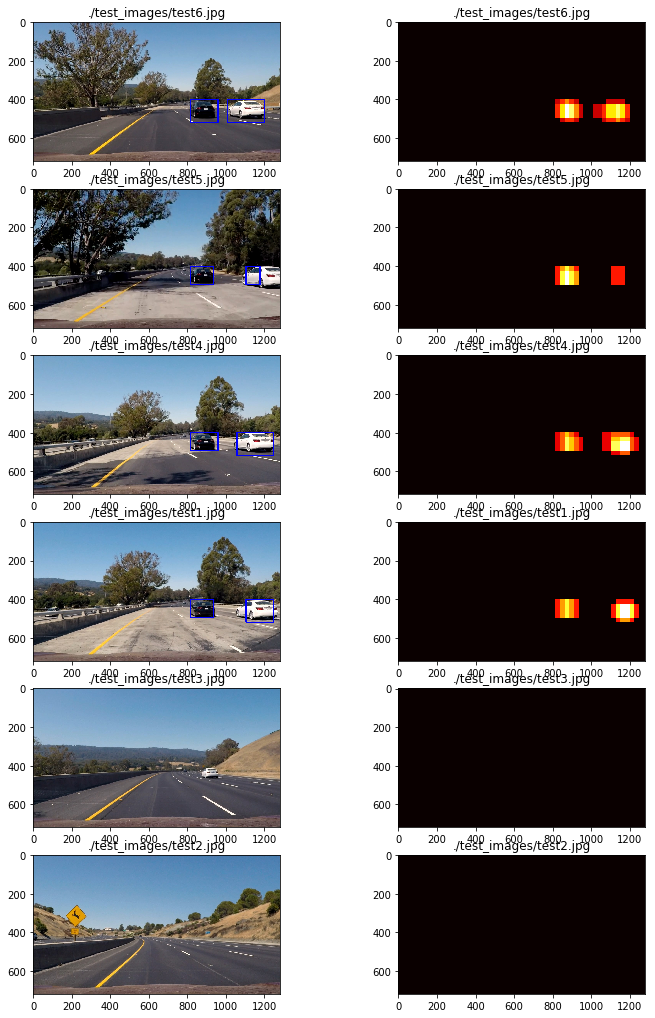

In [16]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

color_convert = 'RGB2YCrCb'
ystart = 400
ystop = 656
scales = [ 1.5, 3.0]
threshold = 1
cells_per_step = 2 # instead of overlap

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scales)
    heat_map = apply_threshold(heat_map, threshold)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src)
    out_titles.append(img_src)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [17]:
ystart = 400
ystop = 656
scales = [1.5, 3.0]
window_scaler = len(scales)
#threshold = 2*window_scaler
threshold = 9
avg_heat_map = []
average_length = 15
cells_per_step = 2 #instead of overlap

def process_image(img):
    out_img, heat_map = find_cars(img, scales)
    heat_map = average_heat_map(heat_map, avg_heat_map, average_length)
    heat_map = apply_threshold(heat_map, threshold)
    
    labels = label(heat_map)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

def average_heat_map(new_map, map_list, average_length):
    
    map_list.append(new_map)
    if len(map_list) > average_length:
        del map_list[0]
        
    average_map = np.zeros_like(new_map)
    for hmap in map_list: 
        average_map[hmap > 0] += 1
        
    return average_map

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [07:23<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

